In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.get_mfccs(dataset,
                  blocksize=blocksize, 
                  overlap=overlap,
                  n_mels=128,
                  power_melgram=2.0,
                  decibel_gram=True
                 )

In [11]:
mfcc = pd.concat(df['mfcc'].values, keys=list(range(len(df))))
mfcc.head()

,target,h_target,fold
count,2000.000000,2000.00000,2000.000000
mean,24.500000,0.64000,3.000000
std,14.434479,0.48012,1.414567
min,0.000000,0.00000,1.000000
25%,12.000000,0.00000,2.000000
50%,24.500000,1.00000,3.000000
75%,37.000000,1.00000,4.000000
max,49.000000,1.00000,5.000000


In [34]:
X = ps.quantize_mfccs(mfcc)
y_l = pd.Series(dataset['target'])

AttributeError: 'Audio_Processor' object has no attribute 'quantize_mfccs'

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                        X, y_l, test_size=0.20, random_state=42)

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,5
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,5
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,5
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,5
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,2


# Deep Net
Separate into classes

In [15]:
%%time

clf = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('feat_sel', SelectKBest(k=80, score_func=chi2)),
#     ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
                      max_iter=1000, probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

clf.fit(train_X, train_yy)

CPU times: user 4min 49s, sys: 42.4 s, total: 5min 31s
Wall time: 4min 38s


0.2565248738284066
Confusion matrix, without normalization
[[ 23   0   2 ...   0   2   1]
 [  2  21   2 ...   0   1   0]
 [  0   1  16 ...   0   0   4]
 ...
 [  0   0   1 ...   6   0   0]
 [ 12   1   4 ...   1  34   3]
 [  3   0   0 ...   0   0 105]]


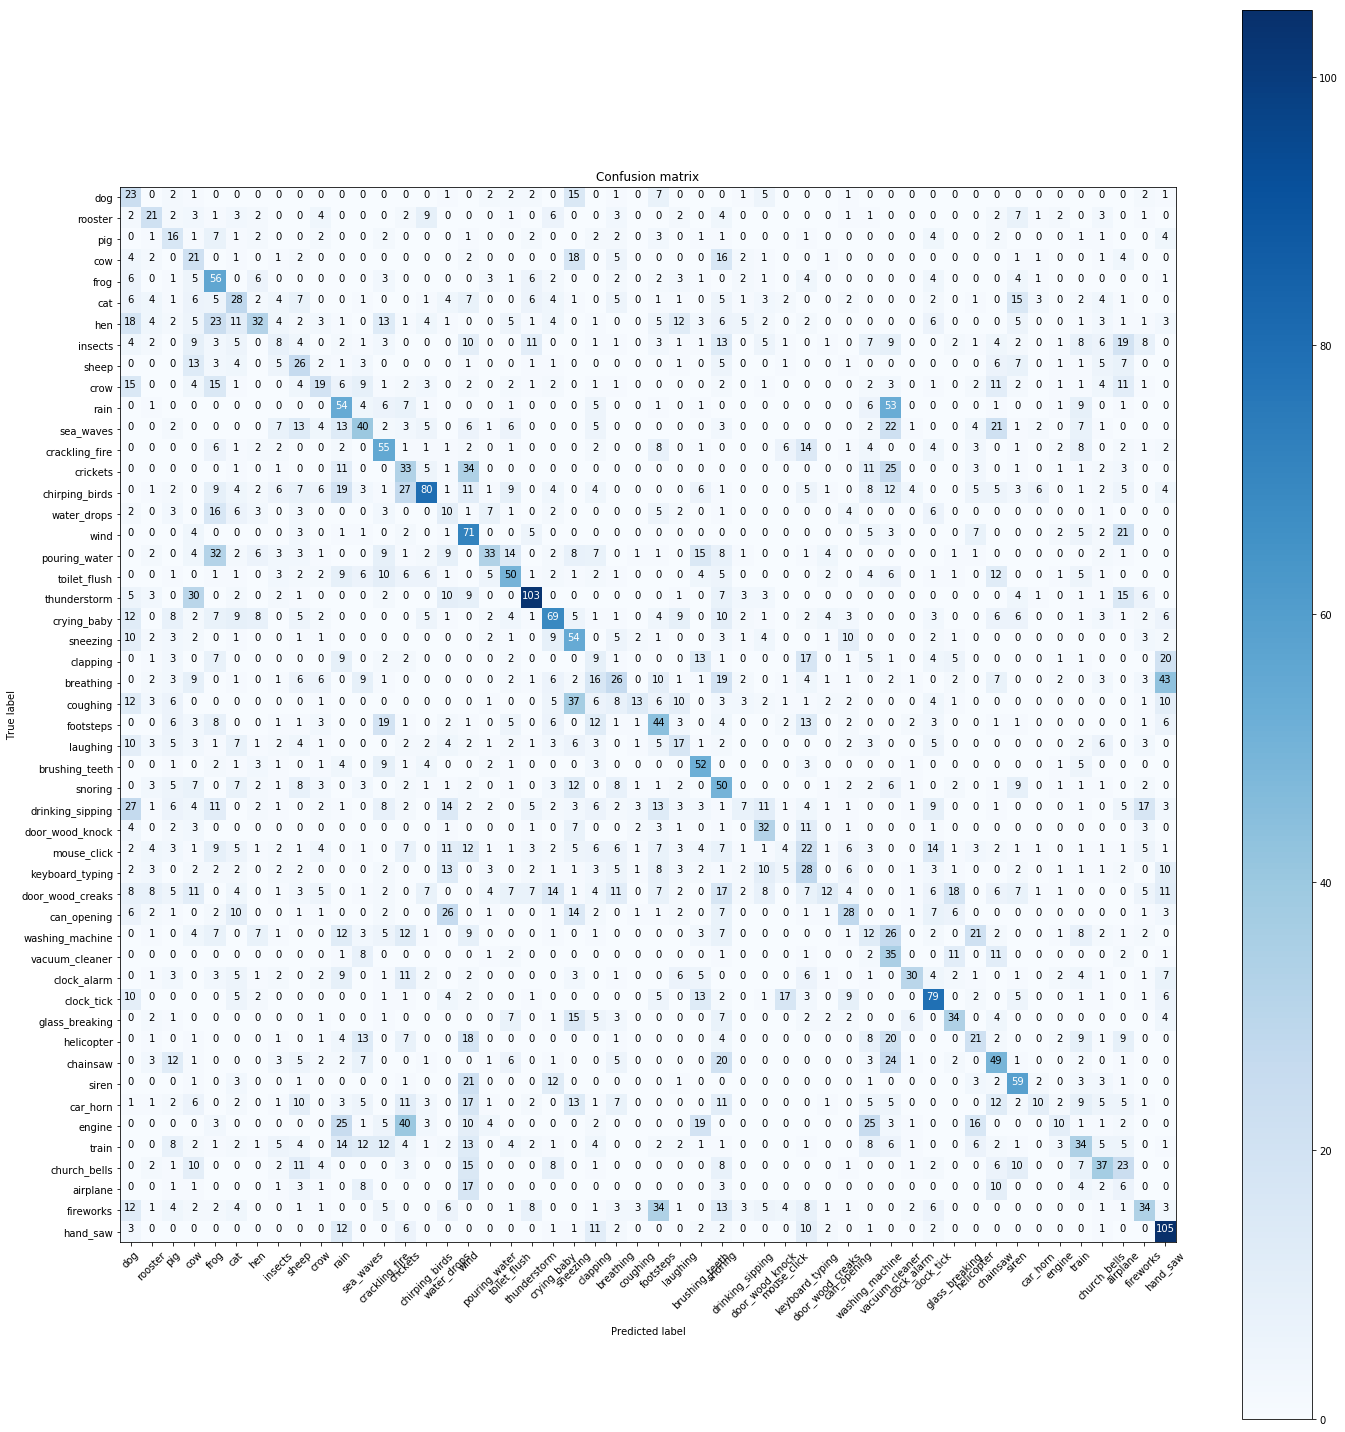

In [16]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_yy, pred))
cm = metrics.confusion_matrix(test_yy, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [17]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = ps.preprocess_file(dataset.iloc[data_iloc].filename,
                                                 blocksize=blocksize,
                                                 overlap=overlap)
    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    pred_probs.append(clf.predict_proba(x_file))
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



Epoch 1/1
2/2 [==============================] - 0s 71ms/step - loss: 1.3268
	File Time: 1.3543829917907715
	File Time: 0.71055006980896
	File Time: 0.5407445430755615
	File Time: 0.5042779445648193
	File Time: 0.515225887298584
	File Time: 0.5078568458557129
	File Time: 0.5028166770935059
	File Time: 0.686739444732666
	File Time: 0.6161348819732666
	File Time: 0.22254014015197754
	File Time: 0.2603628635406494
	File Time: 0.6663830280303955
	File Time: 0.5288081169128418
	File Time: 0.5944795608520508
	File Time: 0.13953614234924316
	File Time: 0.7044193744659424
	File Time: 0.6229410171508789
	File Time: 0.5005967617034912
	File Time: 0.5028769969940186
	File Time: 0.505314826965332
	File Time: 0.5005199909210205
	File Time: 0.49851131439208984
	File Time: 0.6148347854614258
	File Time: 0.703087329864502
	File Time: 0.5312368869781494
	File Time: 0.5037674903869629
	File Time: 0.5993192195892334
	File Time: 0.6348280906677246
	File Time: 0.5144753456115723
	File Time: 0.5091629028320

	File Time: 0.4275679588317871
	File Time: 0.6157310009002686
	File Time: 0.6341400146484375
	File Time: 0.4316694736480713
	File Time: 0.4291510581970215
	File Time: 0.5196082592010498
	File Time: 0.5252351760864258
	File Time: 0.5338907241821289
	File Time: 0.5343282222747803
	File Time: 0.4235067367553711
	File Time: 0.5332615375518799
	File Time: 0.5213232040405273
	File Time: 0.5225696563720703
	File Time: 0.5050914287567139
	File Time: 0.5062732696533203
	File Time: 0.592677116394043
	File Time: 0.5669898986816406
	File Time: 0.6319320201873779
	File Time: 0.31606554985046387
	File Time: 0.49851274490356445
	File Time: 0.44315433502197266
	File Time: 0.3403046131134033
	File Time: 0.49500608444213867
	File Time: 0.4921534061431885
	File Time: 0.4949476718902588
	File Time: 0.4927692413330078
	File Time: 0.466702938079834
	File Time: 0.2631351947784424
	File Time: 0.36586833000183105
	File Time: 0.4413454532623291
	File Time: 0.49153709411621094
	File Time: 0.49173855781555176
	Fi

	File Time: 0.5049965381622314
	File Time: 0.5026614665985107
	File Time: 0.501988410949707
	File Time: 0.5068559646606445
	File Time: 0.5042543411254883
	File Time: 0.5051863193511963
	File Time: 0.5005512237548828
	File Time: 0.5080249309539795
	File Time: 0.5057318210601807
	File Time: 0.5021014213562012
	File Time: 0.5058159828186035
	File Time: 0.2968626022338867
	File Time: 0.5356099605560303
	File Time: 0.7988302707672119
	File Time: 0.7966506481170654
	File Time: 0.6386213302612305
	File Time: 0.19012689590454102
	File Time: 0.5036025047302246
	File Time: 0.18981599807739258
	File Time: 0.4264950752258301
	File Time: 0.5050153732299805
	File Time: 0.5056707859039307
	File Time: 0.5008149147033691
	File Time: 0.512336254119873
	File Time: 0.21650266647338867
	File Time: 0.2708711624145508
	File Time: 0.506070613861084
	File Time: 0.2441394329071045
	File Time: 0.5012109279632568
	File Time: 0.5032947063446045
	File Time: 0.5033113956451416
	File Time: 0.5019640922546387
	File Ti

	File Time: 0.505120038986206
	File Time: 0.5068597793579102
	File Time: 0.31739330291748047
	File Time: 0.16245150566101074
	File Time: 0.4976944923400879
	File Time: 0.5933637619018555
	File Time: 0.6302385330200195
	File Time: 0.5032773017883301
	File Time: 0.521240234375
	File Time: 0.5098543167114258
	File Time: 0.5160868167877197
	File Time: 0.504793643951416
	File Time: 0.5057809352874756
	File Time: 0.509160041809082
	File Time: 0.5091962814331055
	File Time: 0.5071935653686523
	File Time: 0.5058028697967529
	File Time: 0.5051219463348389
	File Time: 0.5031414031982422
	File Time: 0.5078444480895996
	File Time: 0.5042846202850342
	File Time: 0.516871452331543
	File Time: 0.5069949626922607
	File Time: 0.5040690898895264
	File Time: 0.5061700344085693
	File Time: 0.5058994293212891
	File Time: 0.5029640197753906
	File Time: 0.45766282081604004
	File Time: 0.5053887367248535
	File Time: 0.5033268928527832
	File Time: 0.5038595199584961
	File Time: 0.5024166107177734
	File Time: 0

	File Time: 0.503324031829834
	File Time: 0.5053036212921143
	File Time: 0.5060939788818359
	File Time: 0.5057871341705322
	File Time: 0.5069015026092529
	File Time: 0.5074481964111328
	File Time: 0.5067093372344971
	File Time: 0.5172278881072998
	File Time: 0.507213830947876
	File Time: 0.5099236965179443
	File Time: 0.5083160400390625
	File Time: 0.14047646522521973
	File Time: 0.508857250213623
	File Time: 0.5082578659057617
	File Time: 0.5049295425415039
	File Time: 0.5093615055084229
	File Time: 0.300464391708374
	File Time: 0.22005844116210938
	File Time: 0.5172233581542969
	File Time: 0.5849442481994629
	File Time: 0.8020291328430176
	File Time: 0.5086023807525635
	File Time: 0.5071747303009033
	File Time: 0.5152909755706787
	File Time: 0.5175681114196777
	File Time: 0.24342036247253418
	File Time: 0.2768266201019287
	File Time: 0.22127699851989746
	File Time: 0.20109891891479492
	File Time: 0.5097320079803467
	File Time: 0.5075774192810059
	File Time: 0.5063705444335938
	File T

	File Time: 0.34917473793029785
	File Time: 0.5102372169494629
	File Time: 0.6022841930389404
	File Time: 0.6751928329467773
	File Time: 0.5009167194366455
	File Time: 0.3643977642059326
	File Time: 0.5086164474487305
	File Time: 0.5178375244140625
	File Time: 0.5096120834350586
	File Time: 0.5081737041473389
	File Time: 0.5053422451019287
	File Time: 0.5036473274230957
	File Time: 0.5150282382965088
	File Time: 0.511380672454834
	File Time: 0.5944685935974121
	File Time: 0.6343140602111816
	File Time: 0.509218692779541
	File Time: 0.6013414859771729
	File Time: 0.616490364074707
	File Time: 0.5161020755767822
	File Time: 0.5013318061828613
	File Time: 0.5077862739562988
	File Time: 0.5992250442504883
	File Time: 0.6643688678741455
	File Time: 0.3043243885040283
	File Time: 0.23131060600280762
	File Time: 0.5051460266113281
	File Time: 0.49334216117858887
	File Time: 0.4943852424621582
	File Time: 0.49626922607421875
	File Time: 0.4931645393371582
	File Time: 0.4960899353027344
	File T

	File Time: 0.503472089767456
	File Time: 0.5024135112762451
	File Time: 0.43212413787841797
	File Time: 0.5142734050750732
	File Time: 0.33006739616394043
	File Time: 0.427750825881958
	File Time: 0.5021500587463379
	File Time: 0.5102450847625732
	File Time: 0.4991581439971924
	File Time: 0.5105390548706055
	File Time: 0.502363920211792
	File Time: 0.5054926872253418
	File Time: 0.527313232421875
	File Time: 0.49480700492858887
	File Time: 0.5930826663970947
	File Time: 0.6142408847808838
	File Time: 0.19055724143981934
	File Time: 0.3466360569000244
	File Time: 0.18337512016296387
	File Time: 0.5980525016784668
	File Time: 0.07506203651428223
	File Time: 0.5141761302947998
	File Time: 0.49640440940856934
	File Time: 0.4977390766143799
	File Time: 0.11680889129638672
	File Time: 0.49771785736083984
	File Time: 0.49841976165771484
	File Time: 0.5074117183685303
	File Time: 0.5087671279907227
	File Time: 0.5069947242736816
	File Time: 0.49979496002197266
	File Time: 0.49970102310180664


	File Time: 0.49160051345825195
	File Time: 0.317765474319458
	File Time: 0.23697948455810547
	File Time: 0.21387267112731934
	File Time: 0.4948091506958008
	File Time: 0.49199414253234863
	File Time: 0.3012535572052002
	File Time: 0.35084104537963867
	File Time: 0.5785448551177979
	File Time: 0.5056626796722412
	File Time: 0.14110493659973145
	File Time: 0.45667362213134766
	File Time: 0.5037796497344971
	File Time: 0.5061659812927246
	File Time: 0.5120992660522461
	File Time: 0.5913121700286865
	File Time: 0.6182711124420166
	File Time: 0.5874228477478027
	File Time: 0.5284879207611084
	File Time: 0.467376708984375
	File Time: 0.5071730613708496
	File Time: 0.5203735828399658
	File Time: 0.506075382232666
	File Time: 0.26618313789367676
	File Time: 0.6249322891235352
	File Time: 0.30719995498657227
	File Time: 0.5170211791992188
	File Time: 0.5168936252593994
	File Time: 0.3008561134338379
	File Time: 0.5146651268005371
	File Time: 0.508368968963623
	File Time: 0.1429591178894043
	Fi

In [18]:
targs = np.vstack(full_targets)

0.515
Confusion matrix, without normalization
[[30  0  0 ...  0  0  1]
 [ 1 22  0 ...  0  1  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 19  0  0]
 [ 2  0  0 ...  0 17  1]
 [ 0  0  0 ...  0  0 37]]


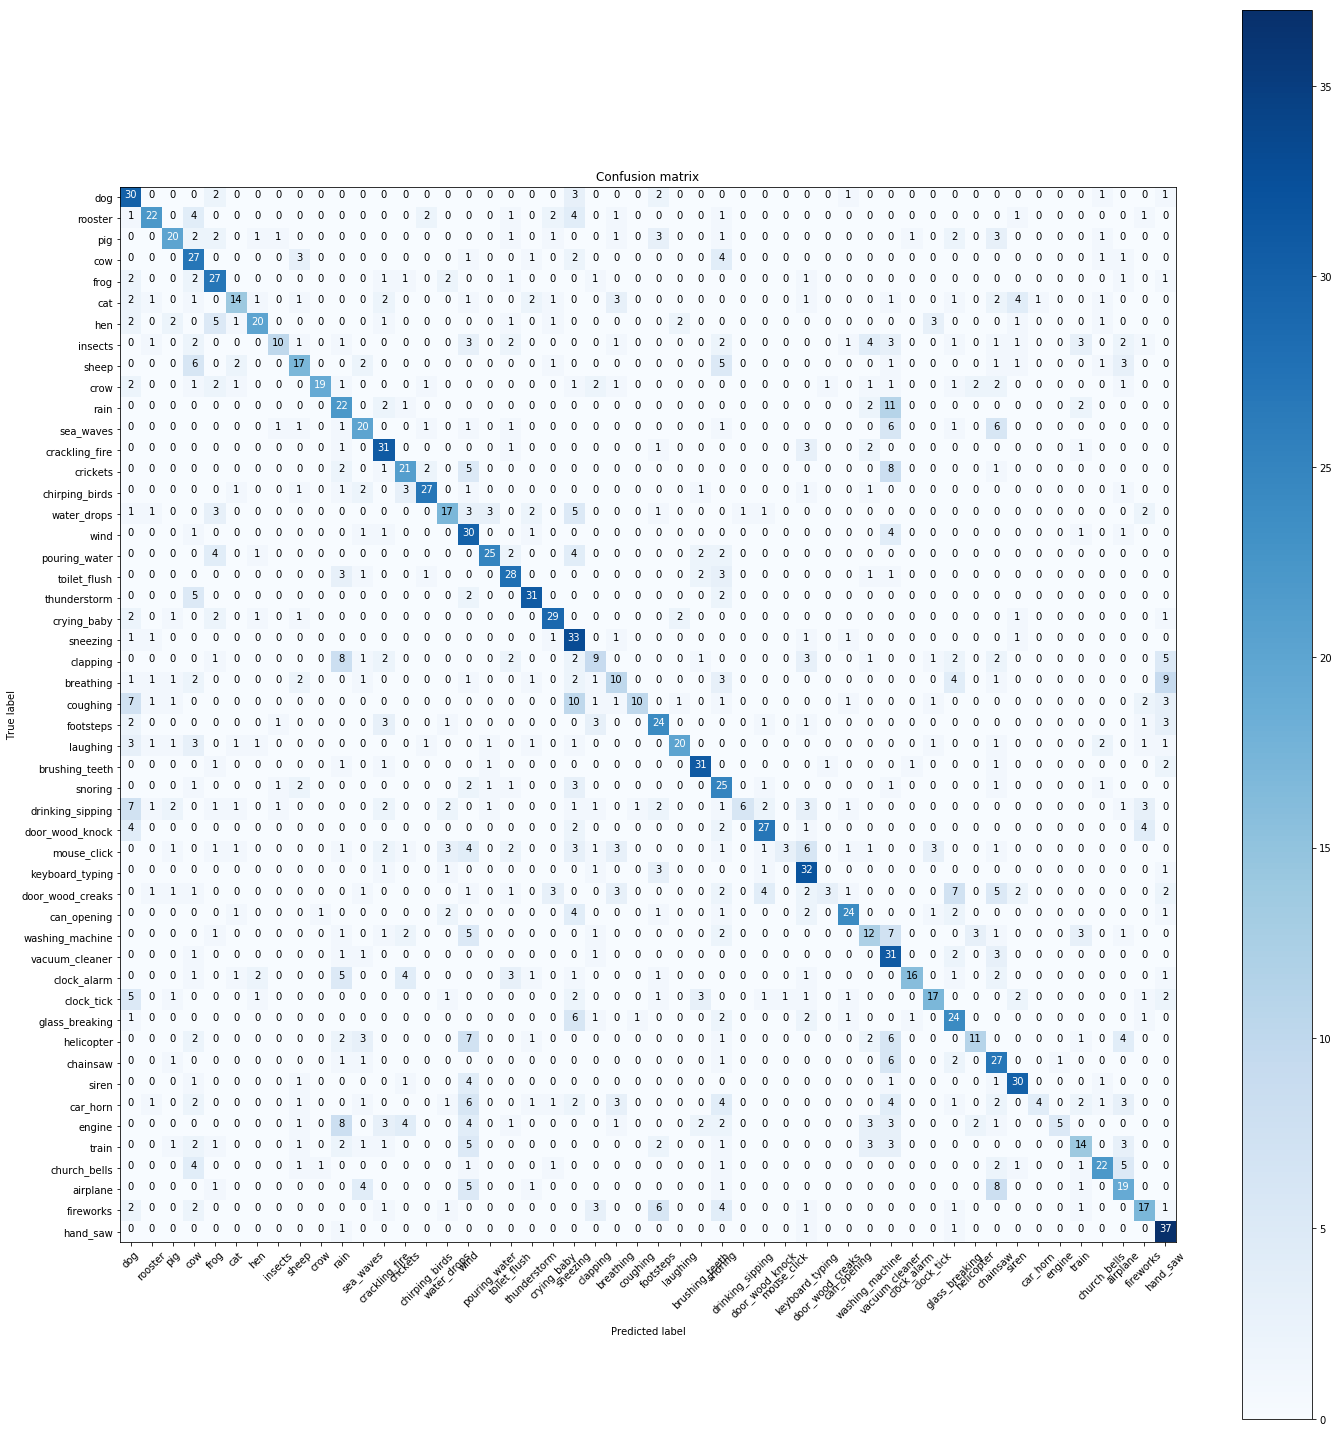

In [19]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [20]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [23]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = t_df.iloc[data_iloc].metadata

    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.04491424560546875
	File Time: 0.09994792938232422
	File Time: 0.07872915267944336
	File Time: 0.07583904266357422
	File Time: 0.07480788230895996
	File Time: 0.06068587303161621
	File Time: 0.03652834892272949
	File Time: 0.05617117881774902
	File Time: 0.055992841720581055
	File Time: 0.019139766693115234
	File Time: 0.019191741943359375
	File Time: 0.05598092079162598
	File Time: 0.05620431900024414
	File Time: 0.05711245536804199
	File Time: 0.010425567626953125
	File Time: 0.05636239051818848
	File Time: 0.056060791015625
	File Time: 0.056490182876586914
	File Time: 0.056227922439575195
	File Time: 0.05675673484802246
	File Time: 0.05641365051269531
	File Time: 0.056456565856933594
	File Time: 0.05645179748535156
	File Time: 0.05667686462402344
	File Time: 0.05563950538635254
	File Time: 0.0565028190612793
	File Time: 0.05639815330505371
	File Time: 0.05590176582336426
	File Time: 0.055716753005981445
	File Time: 0.05637097358703613
	File Time: 0.055811166763305664
	F

	File Time: 0.056661128997802734
	File Time: 0.05562996864318848
	File Time: 0.05586743354797363
	File Time: 0.05597949028015137
	File Time: 0.02462005615234375
	File Time: 0.04814720153808594
	File Time: 0.05567669868469238
	File Time: 0.055640220642089844
	File Time: 0.047135353088378906
	File Time: 0.04758477210998535
	File Time: 0.05664777755737305
	File Time: 0.05586838722229004
	File Time: 0.05574202537536621
	File Time: 0.05631256103515625
	File Time: 0.04516005516052246
	File Time: 0.05584001541137695
	File Time: 0.056081295013427734
	File Time: 0.05647087097167969
	File Time: 0.05631852149963379
	File Time: 0.05552220344543457
	File Time: 0.05553936958312988
	File Time: 0.044461965560913086
	File Time: 0.056005239486694336
	File Time: 0.03564143180847168
	File Time: 0.05601239204406738
	File Time: 0.05011773109436035
	File Time: 0.039755821228027344
	File Time: 0.055754661560058594
	File Time: 0.056116580963134766
	File Time: 0.056130170822143555
	File Time: 0.0566203594207763

	File Time: 0.0563359260559082
	File Time: 0.05570054054260254
	File Time: 0.055737972259521484
	File Time: 0.05616283416748047
	File Time: 0.0562589168548584
	File Time: 0.0561060905456543
	File Time: 0.05596494674682617
	File Time: 0.05590248107910156
	File Time: 0.05677628517150879
	File Time: 0.055756330490112305
	File Time: 0.05560803413391113
	File Time: 0.055600881576538086
	File Time: 0.056336164474487305
	File Time: 0.05587410926818848
	File Time: 0.056087493896484375
	File Time: 0.056002140045166016
	File Time: 0.05674266815185547
	File Time: 0.05596756935119629
	File Time: 0.05576896667480469
	File Time: 0.0558929443359375
	File Time: 0.05611133575439453
	File Time: 0.055971384048461914
	File Time: 0.03294062614440918
	File Time: 0.05566287040710449
	File Time: 0.05721855163574219
	File Time: 0.05979275703430176
	File Time: 0.05902266502380371
	File Time: 0.022873878479003906
	File Time: 0.058745622634887695
	File Time: 0.0234982967376709
	File Time: 0.049532413482666016
	Fi

	File Time: 0.05619359016418457
	File Time: 0.053552865982055664
	File Time: 0.0555415153503418
	File Time: 0.0556635856628418
	File Time: 0.05627584457397461
	File Time: 0.05558323860168457
	File Time: 0.05592918395996094
	File Time: 0.03342747688293457
	File Time: 0.056236982345581055
	File Time: 0.05645442008972168
	File Time: 0.056381940841674805
	File Time: 0.047455549240112305
	File Time: 0.05102968215942383
	File Time: 0.05655980110168457
	File Time: 0.056417226791381836
	File Time: 0.05596613883972168
	File Time: 0.05625748634338379
	File Time: 0.02757430076599121
	File Time: 0.0558619499206543
	File Time: 0.056287527084350586
	File Time: 0.035974740982055664
	File Time: 0.018993616104125977
	File Time: 0.05624055862426758
	File Time: 0.05606865882873535
	File Time: 0.055845022201538086
	File Time: 0.0560762882232666
	File Time: 0.0559535026550293
	File Time: 0.0558168888092041
	File Time: 0.05605792999267578
	File Time: 0.05562186241149902
	File Time: 0.05610322952270508
	File

	File Time: 0.05892467498779297
	File Time: 0.05800890922546387
	File Time: 0.055411577224731445
	File Time: 0.007530927658081055
	File Time: 0.05041217803955078
	File Time: 0.05661177635192871
	File Time: 0.05588197708129883
	File Time: 0.05586504936218262
	File Time: 0.05561256408691406
	File Time: 0.0563809871673584
	File Time: 0.05634427070617676
	File Time: 0.055855512619018555
	File Time: 0.056082963943481445
	File Time: 0.030214786529541016
	File Time: 0.05642580986022949
	File Time: 0.05589127540588379
	File Time: 0.055634498596191406
	File Time: 0.0359494686126709
	File Time: 0.056038618087768555
	File Time: 0.05697464942932129
	File Time: 0.030237674713134766
	File Time: 0.05572366714477539
	File Time: 0.02720808982849121
	File Time: 0.05632328987121582
	File Time: 0.0561070442199707
	File Time: 0.05589938163757324
	File Time: 0.055891990661621094
	File Time: 0.056946516036987305
	File Time: 0.056870222091674805
	File Time: 0.05625724792480469
	File Time: 0.05586051940917969


	File Time: 0.05605316162109375
	File Time: 0.05578303337097168
	File Time: 0.05560183525085449
	File Time: 0.05614829063415527
	File Time: 0.05668473243713379
	File Time: 0.05610966682434082
	File Time: 0.030175447463989258
	File Time: 0.05579423904418945
	File Time: 0.056061744689941406
	File Time: 0.05665230751037598
	File Time: 0.05593156814575195
	File Time: 0.05565452575683594
	File Time: 0.05582451820373535
	File Time: 0.05614733695983887
	File Time: 0.055635929107666016
	File Time: 0.05565762519836426
	File Time: 0.05569720268249512
	File Time: 0.056809186935424805
	File Time: 0.05562567710876465
	File Time: 0.05545186996459961
	File Time: 0.018923044204711914
	File Time: 0.05590248107910156
	File Time: 0.028117656707763672
	File Time: 0.0562589168548584
	File Time: 0.055707693099975586
	File Time: 0.05559420585632324
	File Time: 0.05627799034118652
	File Time: 0.055905818939208984
	File Time: 0.05580544471740723
	File Time: 0.055890798568725586
	File Time: 0.056535959243774414

	File Time: 0.028696060180664062
	File Time: 0.056175947189331055
	File Time: 0.055730581283569336
	File Time: 0.03308391571044922
	File Time: 0.05613517761230469
	File Time: 0.022647380828857422
	File Time: 0.05606651306152344
	File Time: 0.0561833381652832
	File Time: 0.05605769157409668
	File Time: 0.030489444732666016
	File Time: 0.026104211807250977
	File Time: 0.05829286575317383
	File Time: 0.056455135345458984
	File Time: 0.05635523796081543
	File Time: 0.05793046951293945
	File Time: 0.03635287284851074
	File Time: 0.061244964599609375
	File Time: 0.02301812171936035
	File Time: 0.056754350662231445
	File Time: 0.056739091873168945
	File Time: 0.05597639083862305
	File Time: 0.05560779571533203
	File Time: 0.0555720329284668
	File Time: 0.05658268928527832
	File Time: 0.05634951591491699
	File Time: 0.055889129638671875
	File Time: 0.05576729774475098
	File Time: 0.05595970153808594
	File Time: 0.05663919448852539
	File Time: 0.056395530700683594
	File Time: 0.0563907623291015

	File Time: 0.05653500556945801
	File Time: 0.05587196350097656
	File Time: 0.05575680732727051
	File Time: 0.05894780158996582
	File Time: 0.052687644958496094
	File Time: 0.0557255744934082
	File Time: 0.05561709403991699
	File Time: 0.056128740310668945
	File Time: 0.05718708038330078
	File Time: 0.056182146072387695
	File Time: 0.05624580383300781
	File Time: 0.0560002326965332
	File Time: 0.0564732551574707
	File Time: 0.05818009376525879
	File Time: 0.058992862701416016
	File Time: 0.05784296989440918
	File Time: 0.056554317474365234
	File Time: 0.055858612060546875
	File Time: 0.05577731132507324
	File Time: 0.05610060691833496
	File Time: 0.05727815628051758
	File Time: 0.056349754333496094
	File Time: 0.05596160888671875
	File Time: 0.05664825439453125
	File Time: 0.05394911766052246
	File Time: 0.05677628517150879
	File Time: 0.055770158767700195
	File Time: 0.05573129653930664
	File Time: 0.05639910697937012
	File Time: 0.05600929260253906
	File Time: 0.05570077896118164
	Fi

0.515
0.5833809867136527
Confusion matrix, without normalization
[[30  0  0 ...  0  0  1]
 [ 1 22  0 ...  0  1  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ... 19  0  0]
 [ 2  0  0 ...  0 17  1]
 [ 0  0  0 ...  0  0 37]]


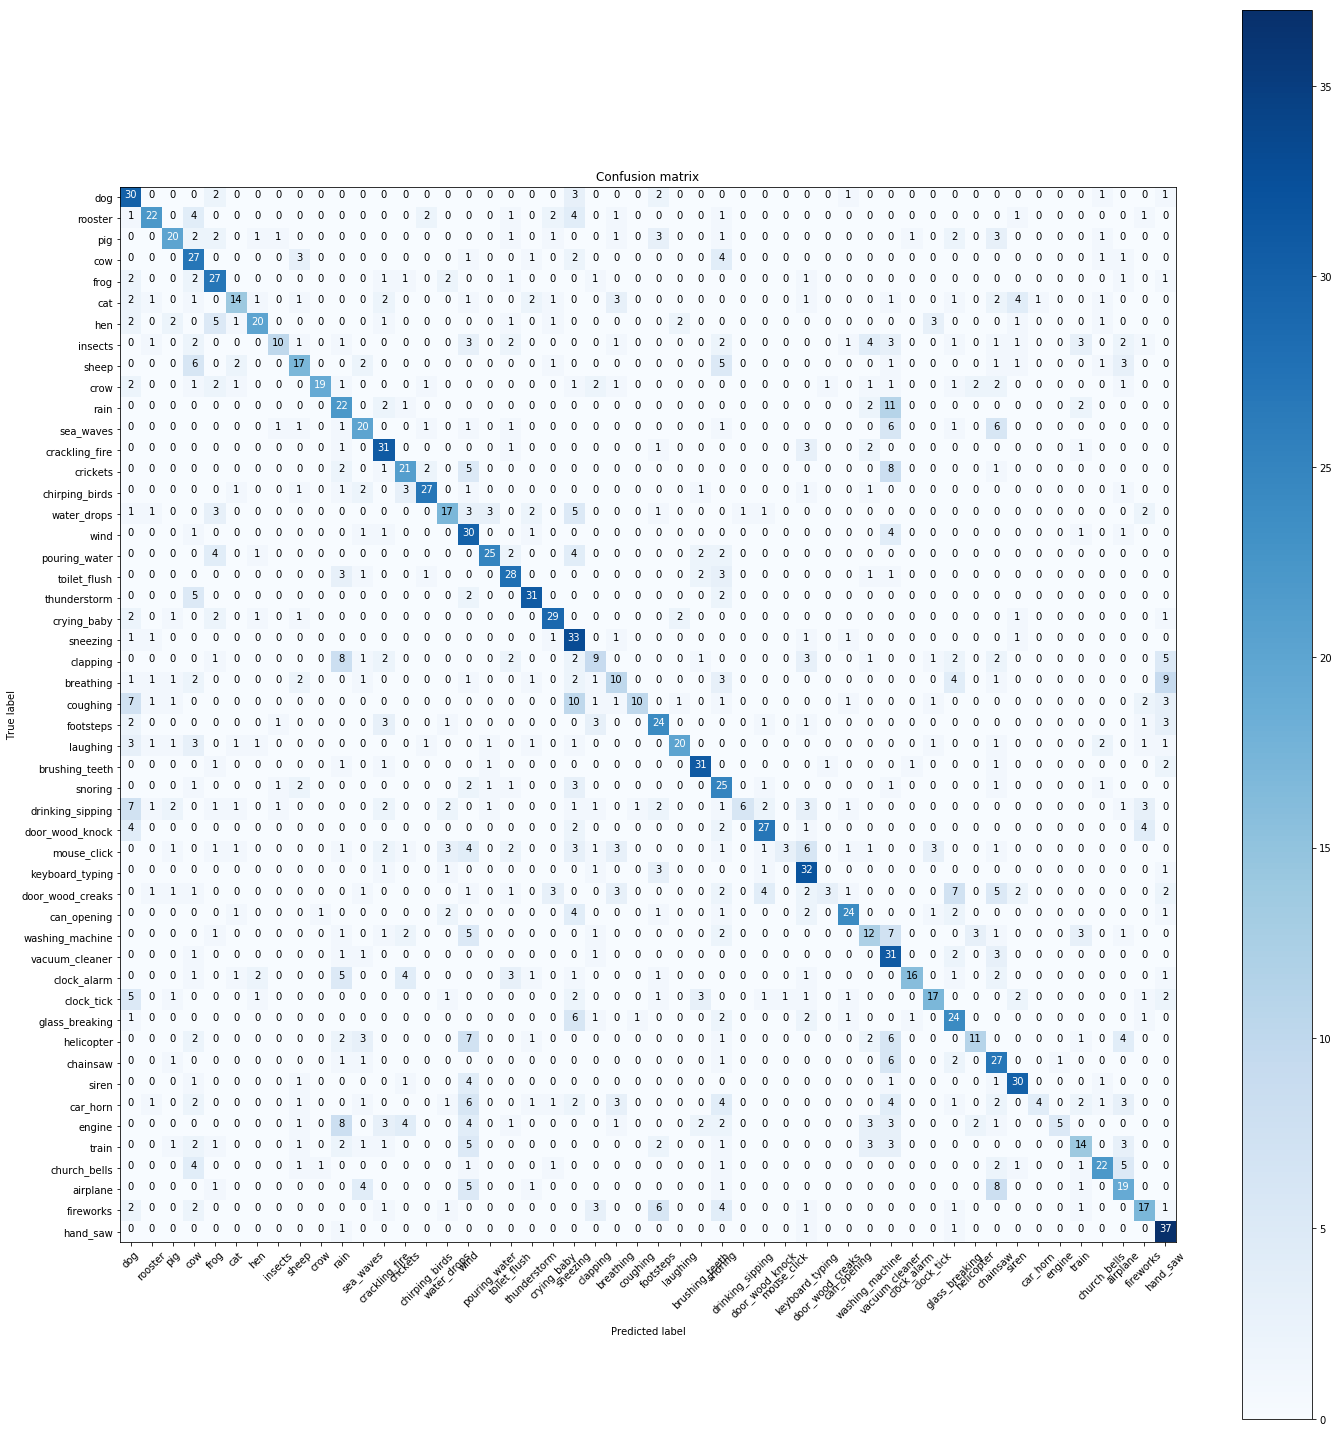

In [24]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [25]:
%%time
from sklearn.model_selection import cross_validate

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50)),
    ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
                      max_iter=1000, probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False)
    )
])

scores = cross_validate(clf, train_X, train_yy, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

CPU times: user 32min 32s, sys: 5min 19s, total: 37min 51s
Wall time: 31min 5s


In [26]:
clf.fit(train_X, train_yy)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fa36ed61378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0...
  max_iter=1000, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [27]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,182.836057,37.973845,0.269369,0.255964,0.263331,0.364279,0.377045,0.358441
1,180.795128,38.530370,0.251481,0.232617,0.245212,0.364737,0.382533,0.358489
2,181.609973,37.835615,0.268034,0.249721,0.262686,0.358062,0.364926,0.351517
3,183.128921,37.830505,0.251668,0.251058,0.249745,0.367221,0.376505,0.360371
4,185.096688,37.888023,0.254969,0.250838,0.249933,0.372130,0.390622,0.367056


In [28]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(test)):
        x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [29]:
%%time
preds = query_dataset('dog')

CPU times: user 41.5 s, sys: 0 ns, total: 41.5 s
Wall time: 41.5 s


In [30]:
preds.head()

,ds_id,file,prediction,prob
0,290,1-58792-A-24.wav,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48,...",0.654840
1,293,1-58923-B-27.wav,"[0, 0, 0, 0, 0, 30, 0, 0, 0, 30, 30, 30, 0, 30...",0.365741
2,366,1-81883-A-21.wav,"[0, 0, 0, 0, 0, 19, 30]",0.311985
3,256,1-51805-E-33.wav,"[29, 3, 0, 0, 0, 30]",0.227229
4,278,1-56234-A-9.wav,"[34, 0, 15, 15, 6, 0, 34, 38, 0, 38, 0, 0, 0, ...",0.204081


In [31]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [32]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['coughing', 'brushing_teeth', 'sneezing', 'door_wood_creaks', 'crow', 'crying_baby', 'clock_tick', 'breathing', 'drinking_sipping', 'helicopter']



0.0

In [33]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)

dog
['coughing', 'brushing_teeth', 'sneezing', 'door_wood_creaks', 'crow', 'crying_baby', 'clock_tick', 'breathing', 'drinking_sipping', 'helicopter']

0.0
rooster
['door_wood_knock', 'clock_alarm', 'clock_alarm', 'cow', 'door_wood_knock', 'sea_waves', 'helicopter', 'dog', 'clock_alarm', 'snoring']

0.0
pig
['fireworks', 'clapping', 'glass_breaking', 'laughing', 'washing_machine', 'mouse_click', 'hand_saw', 'pouring_water', 'coughing', 'airplane']

0.0
cow
['snoring', 'cat', 'church_bells', 'can_opening', 'crow', 'door_wood_knock', 'toilet_flush', 'keyboard_typing', 'breathing', 'train']

0.0
frog
['crickets', 'thunderstorm', 'laughing', 'car_horn', 'fireworks', 'hand_saw', 'vacuum_cleaner', 'vacuum_cleaner', 'mouse_click', 'sneezing']

0.0
cat
['wind', 'can_opening', 'car_horn', 'chainsaw', 'cow', 'cow', 'dog', 'clapping', 'clock_alarm', 'wind']

0.0
hen
['keyboard_typing', 'rain', 'crickets', 'snoring', 'clapping', 'door_wood_knock', 'church_bells', 'clock_tick', 'fireworks', 'pig']


0.01